In [2]:
# FOR IMPORTING DATA AND CONVERTING IT INTO CSV FORM
import pandas as pd
data= pd.read_csv("Inconel825.csv")
data.head()

,Ton,Toff,Current,Ra,Mrr
0,20,10,5,3.08,5.76
1,20,10,1,2.21,1.11
2,50,10,3,3.46,4.77
3,80,10,1,4.26,1.32
4,50,15,5,4.05,5.48


In [3]:
# FOR GRAPHS
import matplotlib.pyplot as plt  #LIBRARY
import seaborn as sns           #LIBRARY

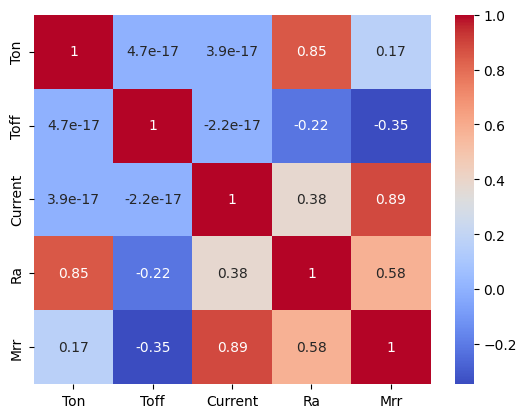

In [4]:
# FINDING CORELATION BETWEEN FEATURES
a=data.corr()
sns.heatmap(a, annot=True, cmap="coolwarm")
plt.show()

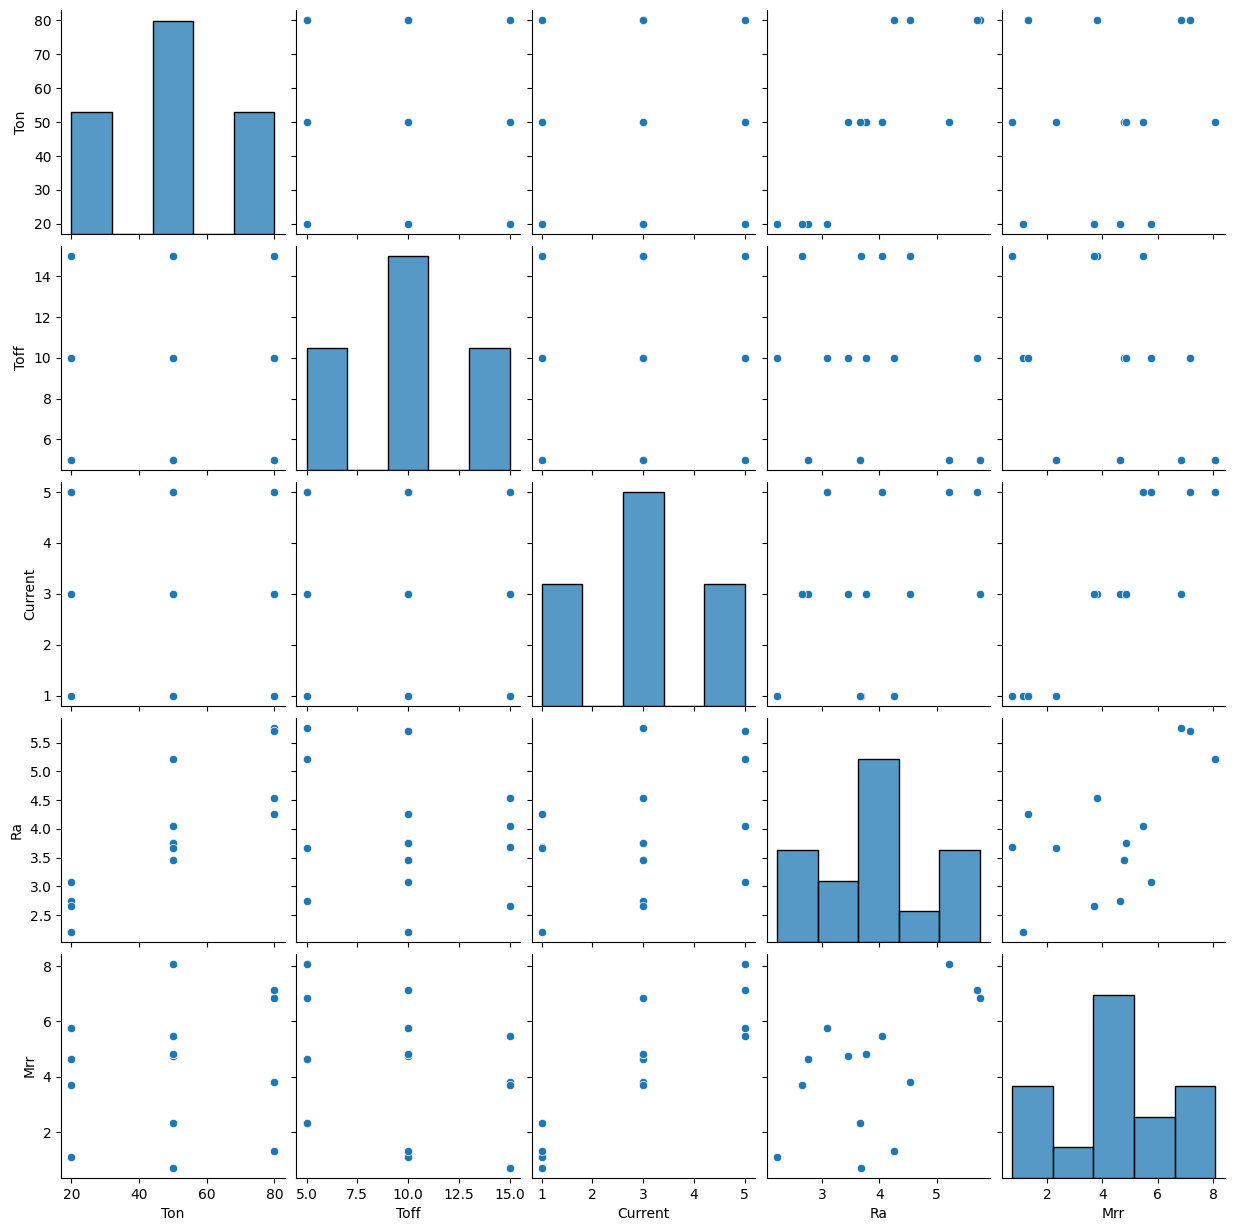

In [5]:
#MAKING PAIR PLOT FOR COMPARISON AND FINDING DEGREE OF RELATION
sns.pairplot(data=data)
plt.show()

In [6]:
# REQUIRED LIBRARIES
from sklearn.model_selection import train_test_split #FOR DIVIDING DATA INTO TRAIN AND TEST
from sklearn.preprocessing import PolynomialFeatures, StandardScaler  # FOR FEATURE SCALING AND DECIDING DEGREE OF POLYNOMIAL
from sklearn.linear_model import LinearRegression    #FOR TRAINING MODEL
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  #FOR CALCULATING ACCURACY AND ERROR OR FOR EVALUATE THE TRAINED MODEL

In [7]:
# STEPS FOR DIVIDING DATA INTO TRAIN TEST AND INDEPENDENT AND DEPENDENT
data.drop(columns=["Ra"], inplace=True)
x=data.drop(columns=["Mrr"])
y=data["Mrr"]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.25, random_state=42)

In [8]:
import numpy as np

# POLYNOMIAL REGRESSION FOR MRR:
x=data.drop(columns=["Mrr"])
y=data["Mrr"]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=42)
# Step 1: Create polynomial features (degree=2 for quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Step 2: Feature scaling
scaler = StandardScaler()
x_train_poly_scaled = scaler.fit_transform(x_train_poly)
x_test_poly_scaled = scaler.transform(x_test_poly)

# Step 3: Fit a linear regression model on polynomial features
model = LinearRegression()
model.fit(x_train_poly_scaled, y_train)

# Step 4: Predict and evaluate
y_pred_test = model.predict(x_test_poly_scaled)
y_pred_train = model.predict(x_train_poly_scaled)

# Calculate metrics for BOTH train and test sets
metrics = {
    'Train': {
        'MSE': mean_squared_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R²': r2_score(y_train, y_pred_train)
    },
    'Test': {
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R²': r2_score(y_test, y_pred_test)
    }
}

# Print formatted results
print("┌──────────────────┬────────────┬────────────┬────────────┐")
print("│      Dataset     │    MSE     │    RMSE    │     R²     │")
print("├──────────────────┼────────────┼────────────┼────────────┤")
for dataset, values in metrics.items():
    print(f"│ {dataset:<16} │ {values['MSE']:>10.4f} │ {values['RMSE']:>10.4f} │ {values['R²']:>10.4f} │")
print("└──────────────────┴────────────┴────────────┴────────────┘")

# Optional: Print the gap between train and test performance
train_test_gap = {
    'MSE Gap': metrics['Train']['MSE'] - metrics['Test']['MSE'],
    'R² Gap': metrics['Train']['R²'] - metrics['Test']['R²']
}
print(f"\nTrain-Test Performance Gaps:")
print(f"• MSE Difference: {train_test_gap['MSE Gap']:.4f}")
print(f"• R² Difference:  {train_test_gap['R² Gap']:.4f}")
# Step 5: OPTIMISATION: find the process parameters that maximise MRR
#    • We use Optuna for Bayesian optimisation.
import optuna
# Define bounds for each feature
param_bounds = {
    col: (x_train[col].min(), x_train[col].max())   # automatic
    for col in x_train.columns
}
param_bounds["Ton"] = (20, 80)     # µs
param_bounds["Toff"] = (5, 15)      # µs
param_bounds["Current"] = (1, 5)   # A

# Keep feature order consistent with training
feature_order = list(x_train.columns)

# Objective function for Optuna
def objective(trial):
    candidate = {
        feat: trial.suggest_float(feat, low, high)
        for feat, (low, high) in param_bounds.items()
    }
    
    # Transform → predict MRR
    X_new = pd.DataFrame([candidate])[feature_order]
    X_new_poly    = poly.transform(X_new)
    X_new_scaled  = scaler.transform(X_new_poly)
    mrr_predicted = model.predict(X_new_scaled)[0]

    # Optuna will *maximize* this value
    return mrr_predicted

# Run the Bayesian search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Report the best setting
best_params = study.best_trial.params
best_mrr    = study.best_value

print("\n================ OPTIMISATION RESULT ================")
for k, v in best_params.items():
    print(f"{k:10s}: {v:.3f}")
print(f"Predicted MRR : {best_mrr:.4f}")

┌──────────────────┬────────────┬────────────┬────────────┐
│      Dataset     │    MSE     │    RMSE    │     R²     │
├──────────────────┼────────────┼────────────┼────────────┤
│ Train            │     0.0002 │     0.0154 │     0.9999 │
│ Test             │     0.1096 │     0.3311 │     0.9798 │
└──────────────────┴────────────┴────────────┴────────────┘

Train-Test Performance Gaps:
• MSE Difference: -0.1094
• R² Difference:  0.0202


[I 2025-09-24 21:00:37,220] A new study created in memory with name: no-name-ac031a51-6007-4ba6-b5c7-d520cfbfcabb


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-24 21:00:37,248] Trial 0 finished with value: 3.1659282590357725 and parameters: {'Ton': 34.77491586303572, 'Toff': 11.873122272619854, 'Current': 2.2178215368244736}. Best is trial 0 with value: 3.1659282590357725.
[I 2025-09-24 21:00:37,257] Trial 1 finished with value: 2.1453984516313533 and parameters: {'Ton': 67.44818882395901, 'Toff': 6.128624011572662, 'Current': 1.0199950390131693}. Best is trial 0 with value: 3.1659282590357725.
[I 2025-09-24 21:00:37,265] Trial 2 finished with value: 5.385407176726295 and parameters: {'Ton': 64.22100219249396, 'Toff': 7.5604914741530616, 'Current': 2.817006574665773}. Best is trial 2 with value: 5.385407176726295.
[I 2025-09-24 21:00:37,273] Trial 3 finished with value: 7.1665559274689 and parameters: {'Ton': 63.64463897662523, 'Toff': 6.257411121800567, 'Current': 3.8208466207110043}. Best is trial 3 with value: 7.1665559274689.
[I 2025-09-24 21:00:37,280] Trial 4 finished with value: 2.4231346488022836 and parameters: {'Ton': 51.

In [9]:
# regression equation
feature_names = poly.get_feature_names_out(input_features=['Ton', 'Toff', 'Current'])
# Show the equation
terms = [f"{coef:.4f}*{name}" for coef, name in zip(model.coef_, feature_names)]
equation = " + ".join(terms) + f" + {model.intercept_:.4f}"
print("Regression Equation:")
print(f"y = {equation}")

Regression Equation:
y = 0.8800*Ton + 0.2525*Toff + 3.0954*Current + -0.1615*Ton^2 + -1.1254*Ton Toff + 0.6855*Ton Current + 0.0139*Toff^2 + -0.5858*Toff Current + -1.5255*Current^2 + 4.4589


In [10]:
# FOR ADJUSTED R2 VALUE
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

adj_r2 = adjusted_r2(r2_score(y_train, y_pred_train), n=len(y_train), p=x_train.shape[1])
print("Adjusted R²:", adj_r2)

Adjusted R²: 0.999915522654858


In [11]:
# FOR CROSS-VALIDATION SCORE
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, scoring='r2', cv=5)
print("Cross-Validation R² scores for MRR: ", scores)
print("Mean Cross-Validation R²:", scores.mean())

Cross-Validation R² scores for MRR:  [0.88993716 0.81173261 0.5681851  0.80612108 0.87146927]
Mean Cross-Validation R²: 0.789489043725504


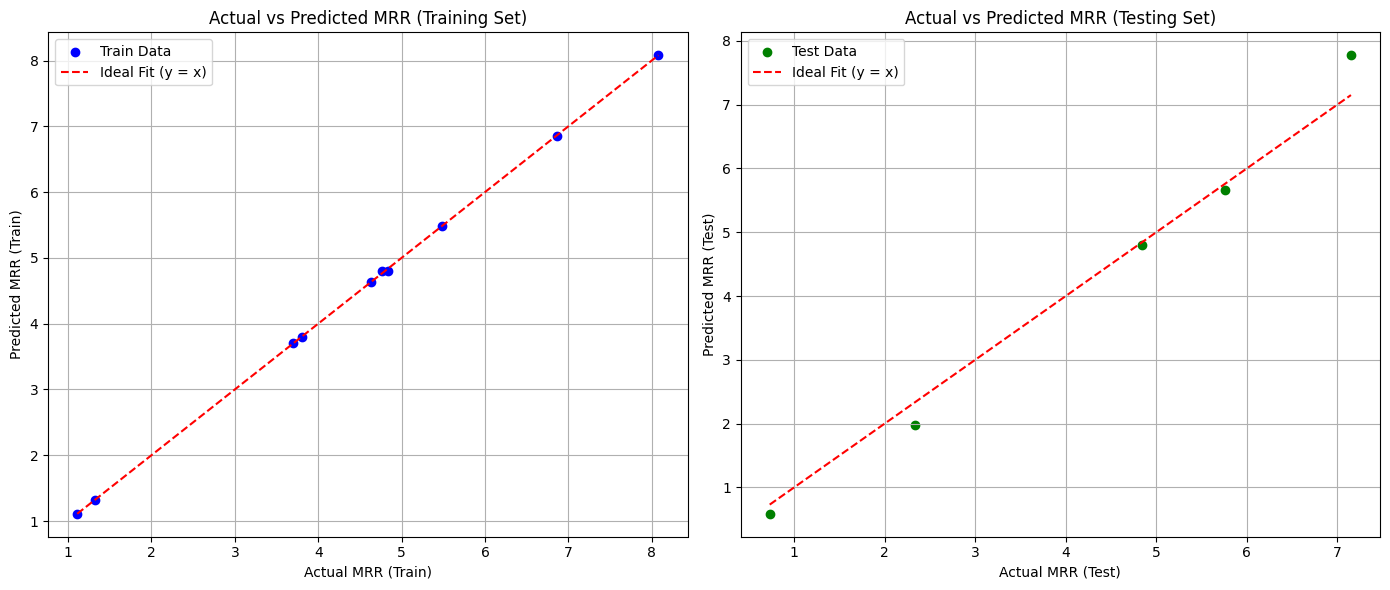

In [12]:
#GRAPGH BETWEEN ACTUAL AND PRIDCTION 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual MRR (Train)')
plt.ylabel('Predicted MRR (Train)')
plt.title('Actual vs Predicted MRR (Training Set)')
plt.legend()
plt.grid(True)

# Step 6: Plot Actual vs. Predicted for Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual MRR (Test)')
plt.ylabel('Predicted MRR (Test)')
plt.title('Actual vs Predicted MRR (Testing Set)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Performance on Test Set:
Mean Squared Error (MSE): 0.1096
Mean Absolute Error (MAE): 0.2529
R² Score: 0.9798


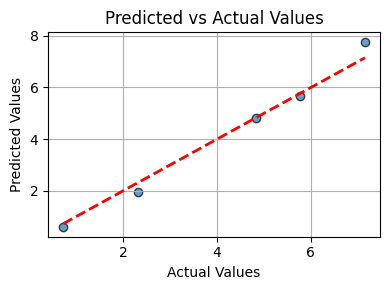

In [13]:
# GRAPH BETWEEN ACTUAL AND PREDICTED VALUES

import numpy as np
# === 1. Predict on test data ===
y_pred = model.predict(x_test_poly_scaled)

# === 2. Performance Metrics ===
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# === 3. Predicted vs Actual Plot ===
plt.figure(figsize=(4, 3))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
#COMPARISON WITH OTHER METHODS:

In [15]:
# RANDOM FOREST FOR MRR:
from sklearn.ensemble import RandomForestRegressor# Required library

rf_model = RandomForestRegressor(random_state=56)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.5520154363112872
R2 Score: 0.8980680181973474


In [16]:
# DECISION TREE FOR MRR:
from sklearn.tree import DecisionTreeRegressor# Required library

model_mrr = DecisionTreeRegressor(random_state=0)
model_mrr.fit(x_train, y_train)
y_pred = model_mrr.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.90028645
R2 Score: 0.8337583045651902


In [17]:
# RIDGE REGRESSOR FOR MRR:
from sklearn.linear_model import RidgeCV  # Required library

ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge.fit(x_train, y_train)
print("RidgCV R²: ", ridge.score(x_test, y_test))
y_pre=ridge.predict(x_test)
mse = mean_squared_error(y_test, y_pre)
print("Mean Squared Error: ",mse)

RidgCV R²:  0.9369437208860404
Mean Squared Error:  0.34148300476144466


In [18]:
# CROSS-VALIDATION SCORE OF RIDGE REGRESSOR MODEL
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge, x, y, scoring='r2', cv=5)
print("ridge CV R² scores:", scores)
print("Mean CV R²:", scores.mean())

ridge CV R² scores: [0.89140761 0.81138557 0.56816352 0.80809557 0.87094638]
Mean CV R²: 0.7899997298665811


In [19]:
#MULTI-OBJECTIVE OPTIMIZATION

In [20]:
from sklearn.multioutput import MultiOutputRegressor

# ---------- STEP 1: Data Splitting ----------
data= pd.read_csv("Inconel825.csv")
x = data.drop(columns=["Mrr", "Ra"])
y = data[["Mrr", "Ra"]]  # Multi-output targets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# ---------- STEP 2: Polynomial Features ----------
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# ---------- STEP 3: Feature Scaling ----------
scaler = StandardScaler()
x_train_poly_scaled = scaler.fit_transform(x_train_poly)
x_test_poly_scaled = scaler.transform(x_test_poly)

# ---------- STEP 4: MultiOutput Regression Model ----------
base_model = LinearRegression()
model = MultiOutputRegressor(base_model)
model.fit(x_train_poly_scaled, y_train)

# ---------- STEP 5: Evaluation ----------
y_pred_train = model.predict(x_train_poly_scaled)
y_pred_test = model.predict(x_test_poly_scaled)

def evaluate_model(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred, multioutput='raw_values')
    return {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

train_metrics = evaluate_model(y_train, y_pred_train)
test_metrics  = evaluate_model(y_test, y_pred_test)

print("\n┌───────────┬────────────┬────────────┬")
print("│  Metric   │    MRR     │     Ra     │")
print("├───────────┼────────────┼────────────┼")
print(f"│ Train MSE │ {train_metrics['MSE'][0]:10.4f} │ {train_metrics['MSE'][1]:10.4f} │")
print(f"│ Test  MSE │ {test_metrics['MSE'][0]:10.4f} │ {test_metrics['MSE'][1]:10.4f} │")
print("└───────────┴────────────┴────────────┴")

# ---------- STEP 6: Multi-Objective Optimization (maximize MRR, minimize Ra) ----------
param_bounds = {
    "Ton": (20, 80),     # µs
    "Toff": (5, 15),     # µs
    "Current": (1, 5)    # A
}
feature_order = list(param_bounds.keys())

def objective(trial):
    candidate = {
        feat: trial.suggest_float(feat, low, high)
        for feat, (low, high) in param_bounds.items()
    }

    X_new = pd.DataFrame([candidate])[feature_order]
    X_new_poly = poly.transform(X_new)
    X_new_scaled = scaler.transform(X_new_poly)
    mrr_pred, ra_pred = model.predict(X_new_scaled)[0]

    # Combine objectives into a single score
    # You can adjust the weight (alpha) as needed
    alpha = 0.5  # balance between MRR and Ra
    score = alpha * mrr_pred - (1 - alpha) * ra_pred  # maximize MRR, minimize Ra
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# ---------- STEP 7: Report Best Parameters ----------
best_params = study.best_params
X_best = pd.DataFrame([best_params])[feature_order]
X_best_poly = poly.transform(X_best)
X_best_scaled = scaler.transform(X_best_poly)
best_mrr, best_ra = model.predict(X_best_scaled)[0]

print("\n=============== OPTIMIZATION RESULT ===============")
for k, v in best_params.items():
    print(f"{k:10s}: {v:.3f}")
print(f"Predicted MRR : {best_mrr:.4f}")
print(f"Predicted Ra  : {best_ra:.4f}")


[I 2025-09-24 21:03:12,249] A new study created in memory with name: no-name-1f3ecd60-9b66-4b16-8858-5d12e0f76c0c



┌───────────┬────────────┬────────────┬
│  Metric   │    MRR     │     Ra     │
├───────────┼────────────┼────────────┼
│ Train MSE │     0.0002 │     0.0045 │
│ Test  MSE │     0.1096 │     0.2116 │
└───────────┴────────────┴────────────┴


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-24 21:03:12,273] Trial 0 finished with value: -0.07080639623941787 and parameters: {'Ton': 47.75428347569716, 'Toff': 12.988621213185198, 'Current': 2.166425307474773}. Best is trial 0 with value: -0.07080639623941787.
[I 2025-09-24 21:03:12,282] Trial 1 finished with value: 0.8380547433138381 and parameters: {'Ton': 25.283404140514392, 'Toff': 11.358680062991933, 'Current': 3.361333499609152}. Best is trial 1 with value: 0.8380547433138381.
[I 2025-09-24 21:03:12,290] Trial 2 finished with value: 1.0647068282903178 and parameters: {'Ton': 68.57883039254213, 'Toff': 8.131207769440993, 'Current': 4.6726207362896925}. Best is trial 2 with value: 1.0647068282903178.
[I 2025-09-24 21:03:12,300] Trial 3 finished with value: 0.26555576707009654 and parameters: {'Ton': 37.437687117227995, 'Toff': 12.972112454326675, 'Current': 2.4977205364289157}. Best is trial 2 with value: 1.0647068282903178.
[I 2025-09-24 21:03:12,309] Trial 4 finished with value: -0.19686218414413226 and parame

In [21]:
#PREDICTION

In [22]:
import pandas as pd

# Define feature order
feature_order = ["Ton", "Toff", "Current"]

# Step 1: Get user input (you can replace input() with static values if needed)
ton = float(input("Enter Pulse On Time (Ton) in µs: "))
toff = float(input("Enter Pulse Off Time (Toff) in µs: "))
current = float(input("Enter Current (in A): "))

# Step 2: Create DataFrame
X_input = pd.DataFrame([[ton, toff, current]], columns=feature_order)

# Step 3: Polynomial transformation and scaling
X_input_poly = poly.transform(X_input)
X_input_scaled = scaler.transform(X_input_poly)

# Step 4: Predict MRR and Ra
mrr_pred, ra_pred = model.predict(X_input_scaled)[0]

# Step 5: Display result
print("\n===== PREDICTED RESULTS =====")
print(f"Predicted MRR : {mrr_pred:.4f} mm³/min")
print(f"Predicted Ra  : {ra_pred:.4f} µm")

Enter Pulse On Time (Ton) in µs:  10
Enter Pulse Off Time (Toff) in µs:  5
Enter Current (in A):  1



===== PREDICTED RESULTS =====
Predicted MRR : 1.0167 mm³/min
Predicted Ra  : 1.8334 µm


In [24]:





#FOR SURFACE ROUGHNESS






In [25]:
#IMPORTING DATASET
import pandas as pd
data=pd.read_csv("Inconel825.csv")
data.head()

,Ton,Toff,Current,Ra,Mrr
0,20,10,5,3.08,5.76
1,20,10,1,2.21,1.11
2,50,10,3,3.46,4.77
3,80,10,1,4.26,1.32
4,50,15,5,4.05,5.48


In [27]:
data.drop(columns=["Mrr"], inplace=True)

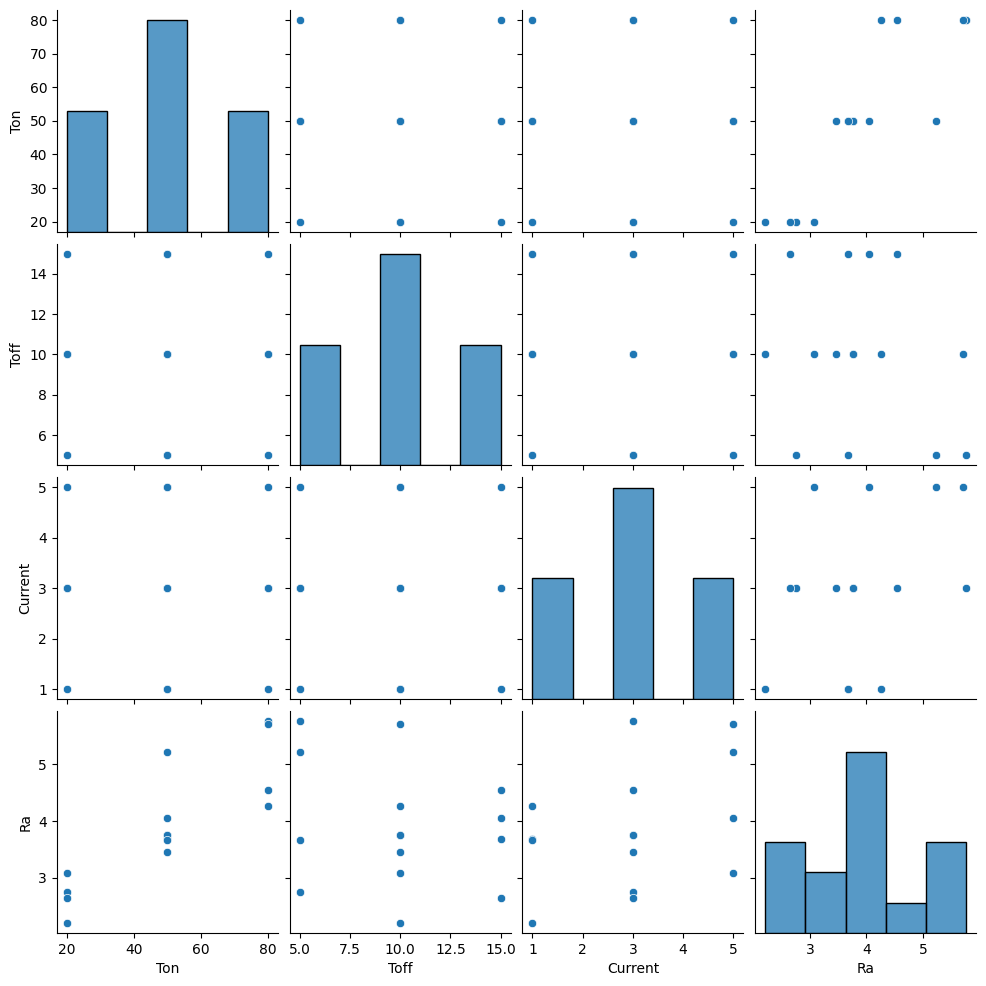

In [28]:
#MAKING PAIR PLOT FOR COMPARISON AND FINDING DEGREE OF RELATION
sns.pairplot(data=data)
plt.show()

In [29]:
# ========== Step 1: Prepare Data ==========
# Assuming your DataFrame is called data1
x = data.drop(columns=["Ra"])
y = data["Ra"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# ========== Step 2: Polynomial Regression ==========
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_poly)
x_test_scaled = scaler.transform(x_test_poly)

model = LinearRegression()
model.fit(x_train_scaled, y_train)

# Predictions and Evaluation
y_pred_train = model.predict(x_train_scaled)
y_pred_test = model.predict(x_test_scaled)

metrics = {
    'Train': {
        'MSE': mean_squared_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R²': r2_score(y_train, y_pred_train)
    },
    'Test': {
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R²': r2_score(y_test, y_pred_test)
    }
}

# Display results
print("┌──────────────────┬────────────┬────────────┬────────────┐")
print("│      Dataset     │    MSE     │    RMSE    │     R²     │")
print("├──────────────────┼────────────┼────────────┼────────────┤")
for dataset, values in metrics.items():
    print(f"│ {dataset:<16} │ {values['MSE']:>10.4f} │ {values['RMSE']:>10.4f} │ {values['R²']:>10.4f} │")
print("└──────────────────┴────────────┴────────────┴────────────┘")

# ========== Step 3: Bayesian Optimization (MINIMIZE Ra) ==========

# Define parameter bounds (customize if needed)
param_bounds = {
    col: (x_train[col].min(), x_train[col].max())
    for col in x_train.columns
}
param_bounds["Ton"] = (20, 80)      # µs
param_bounds["Toff"] = (5, 15)      # µs
param_bounds["Current"] = (1, 5)    # A

feature_order = list(x_train.columns)

# Objective function for Optuna to minimize Surface Roughness
def objective(trial):
    candidate = {
        feat: trial.suggest_float(feat, low, high)
        for feat, (low, high) in param_bounds.items()
    }

    X_new = pd.DataFrame([candidate])[feature_order]
    X_new_poly = poly.transform(X_new)
    X_new_scaled = scaler.transform(X_new_poly)
    ra_pred = model.predict(X_new_scaled)[0]

    return ra_pred  # We want to MINIMIZE Ra

# Run Bayesian Optimization (minimize Ra)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Best Result
best_params = study.best_trial.params
best_ra = study.best_value

print("\n================ OPTIMISATION RESULT FOR Ra ================")
for k, v in best_params.items():
    print(f"{k:10s}: {v:.3f}")
print(f"Predicted Minimum Ra : {best_ra:.4f} µm")


[I 2025-09-24 21:06:39,439] A new study created in memory with name: no-name-43849283-5218-40e4-bd90-02bc5b0b89cf


┌──────────────────┬────────────┬────────────┬────────────┐
│      Dataset     │    MSE     │    RMSE    │     R²     │
├──────────────────┼────────────┼────────────┼────────────┤
│ Train            │     0.0041 │     0.0640 │     0.9962 │
│ Test             │     0.0573 │     0.2393 │     0.9416 │
└──────────────────┴────────────┴────────────┴────────────┘


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-24 21:06:39,457] Trial 0 finished with value: 3.9934239808631653 and parameters: {'Ton': 58.63326684299292, 'Toff': 10.620281698474612, 'Current': 3.3394244326303837}. Best is trial 0 with value: 3.9934239808631653.
[I 2025-09-24 21:06:39,465] Trial 1 finished with value: 3.755929133218819 and parameters: {'Ton': 55.48921338759379, 'Toff': 7.7385256440479235, 'Current': 1.5980744639176159}. Best is trial 1 with value: 3.755929133218819.
[I 2025-09-24 21:06:39,473] Trial 2 finished with value: 3.6079851690605187 and parameters: {'Ton': 58.022831484011974, 'Toff': 10.99883186959155, 'Current': 1.262255704586782}. Best is trial 2 with value: 3.6079851690605187.
[I 2025-09-24 21:06:39,483] Trial 3 finished with value: 2.995619652660377 and parameters: {'Ton': 28.081892920490557, 'Toff': 14.731627100307175, 'Current': 4.104683110990328}. Best is trial 3 with value: 2.995619652660377.
[I 2025-09-24 21:06:39,492] Trial 4 finished with value: 3.6343226491268075 and parameters: {'Ton

In [30]:
# regression equation
feature_names = poly.get_feature_names_out(input_features=['Ton', 'Toff', 'Current'])
# Show the equation
terms = [f"{coef:.4f}*{name}" for coef, name in zip(model.coef_, feature_names)]
equation = " + ".join(terms) + f" + {model.intercept_:.4f}"
print("Regression Equation:")
print(f"y = {equation}")

Regression Equation:
y = 1.3491*Ton + -0.9121*Toff + 0.0763*Current + -0.2574*Ton^2 + -0.5800*Ton Toff + 0.2901*Ton Current + 1.3558*Toff^2 + -0.4835*Toff Current + 0.3336*Current^2 + 3.8491


In [31]:
# FOR ADJUSTED R2 VALUE
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

adj_r2 = adjusted_r2(r2_score(y_train, y_pred_train), n=len(y_train), p=x_train.shape[1])
print("Adjusted R²:", adj_r2)

Adjusted R²: 0.994523231236037


In [32]:
# FOR CROSS-VALIDATION SCORE
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, scoring='r2', cv=3)
print("Cross-Validation R² scores for Ra: ", scores)
print("Mean Cross-Validation R²:", scores.mean())

Cross-Validation R² scores for Ra:  [0.78852779 0.79820663 0.84157262]
Mean Cross-Validation R²: 0.8094356792610102


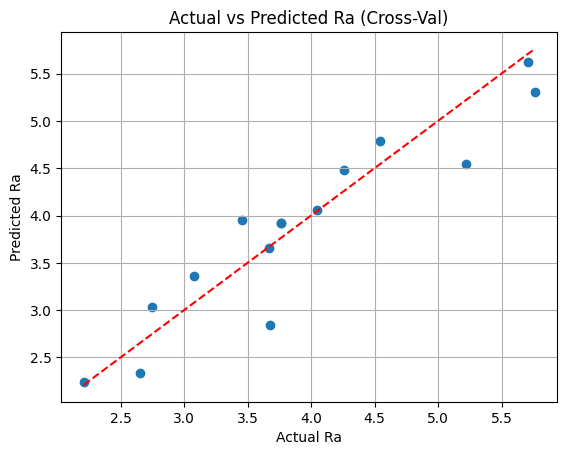

In [33]:
#GRAPGH FOR CROSS VALIDATION SCORE BETWEEN ACTUAL AND PRIDCTION 
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(model, x, y, cv=5)
plt.scatter(y, y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Ra")
plt.ylabel("Predicted Ra")
plt.title("Actual vs Predicted Ra (Cross-Val)")
plt.grid(True)
plt.show()

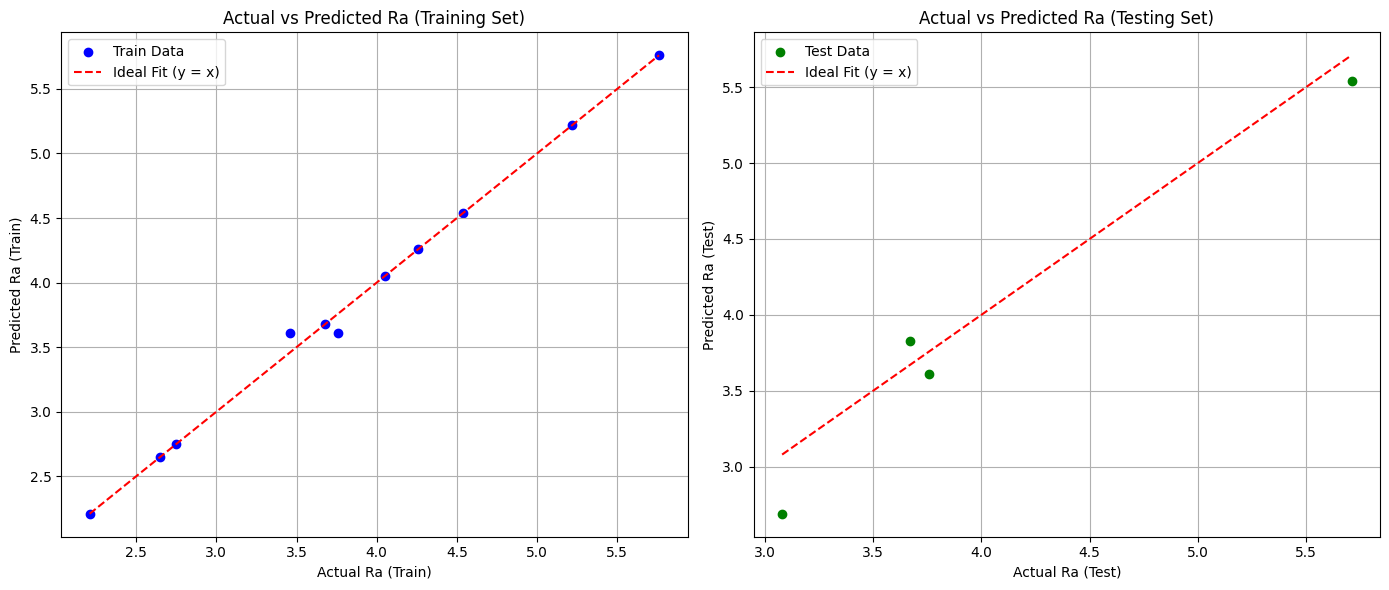

In [34]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual Ra (Train)')
plt.ylabel('Predicted Ra (Train)')
plt.title('Actual vs Predicted Ra (Training Set)')
plt.legend()
plt.grid(True)

# Step 6: Plot Actual vs. Predicted for Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual Ra (Test)')
plt.ylabel('Predicted Ra (Test)')
plt.title('Actual vs Predicted Ra (Testing Set)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
#COMPARISON WITH OTHER METHODS OF MODEL TRAINING

In [36]:
# RANDOM FOREST FOR Ra:
from sklearn.ensemble import RandomForestRegressor# Required library

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.6805819687500017
R2 Score: 0.30639560880531824


In [38]:
# DECISION TREE FOR Ra:
from sklearn.tree import DecisionTreeRegressor  # Required library

model_rad = DecisionTreeRegressor(random_state=0)
model_rad.fit(x_train, y_train)
y_pred = model_rad.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 1.1591
R2 Score: -0.1812785039109277


In [39]:
# RIDGE REGRESSOR FOR Ra:
from sklearn.linear_model import RidgeCV  # Required library

ridge_ra= RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge_ra.fit(x_train, y_train)
print("Ridge R²: ", ridge_ra.score(x_test, y_test))
y_pre=ridge_ra.predict(x_test)
mse = mean_squared_error(y_test, y_pre)
print("Mean Squared Error: ",mse)

Ridge R²:  0.9786239153042694
Mean Squared Error:  0.020974748705568227
